In [0]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.layers import Activation, BatchNormalization, Conv2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.preprocessing.image import array_to_img
from keras import backend as K
from keras.preprocessing.image import save_img

import cv2
import os
import numpy as np
import glob
from xml.dom.minidom import parseString
import matplotlib.pyplot as plt
import keras

classes = 10
inputs = (32,32,3)
input_tensor = Input(shape=inputs)

# データロード
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(np.max(x_train))
print(np.min(x_train))

In [0]:
X_test, X_train, YY_train, YY_test = [], [], [], []

for i in range(len(x_train)):
    if y_train[i] == 0 or y_train[i] == 2:
        pass
    else:
        X_train.append(x_train[i])
        YY_train.append(y_train[i])

for i in range(len(x_test)):
    if y_test[i] == 0 or y_test[i] == 2:
        pass
    else:
        X_test.append(x_test[i])
        YY_test.append(y_test[i])
        
YY_train = to_categorical(YY_train)
YY_test = to_categorical(YY_test)

classes = 10

Epoch 1/100
313/312 [==============================] - 34s 109ms/step - loss: 1.7578 - acc: 0.4788 - val_loss: 1.5277 - val_acc: 0.4627
Epoch 2/100
313/312 [==============================] - 23s 74ms/step - loss: 1.2259 - acc: 0.6226 - val_loss: 1.0625 - val_acc: 0.6180
Epoch 3/100
313/312 [==============================] - 24s 78ms/step - loss: 0.9608 - acc: 0.6895 - val_loss: 0.9919 - val_acc: 0.6643
Epoch 4/100
313/312 [==============================] - 24s 77ms/step - loss: 0.7911 - acc: 0.7422 - val_loss: 0.7924 - val_acc: 0.7210
Epoch 5/100
313/312 [==============================] - 23s 74ms/step - loss: 0.6792 - acc: 0.7791 - val_loss: 0.6835 - val_acc: 0.7631
Epoch 6/100
313/312 [==============================] - 24s 76ms/step - loss: 0.6013 - acc: 0.8007 - val_loss: 0.8241 - val_acc: 0.7365
Epoch 7/100
313/312 [==============================] - 24s 76ms/step - loss: 0.5393 - acc: 0.8215 - val_loss: 0.6824 - val_acc: 0.7855
Epoch 8/100
313/312 [==============================] -

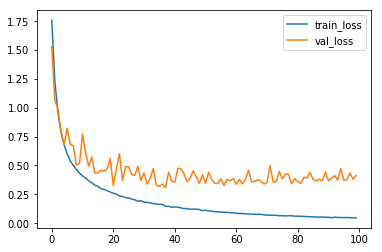

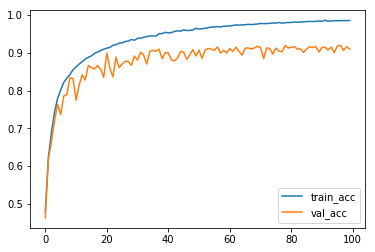

In [0]:
#cnnの構築
alpha = 5

inputs = Input(shape=x_train.shape[1:])#横の数、縦の数、RGB

c = Conv2D(64, (1, 1), padding="same")(inputs)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)

c = Conv2D(128, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(128, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(128, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)

c = Conv2D(256, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(256, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(256, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu", name="out")(c)

c = GlobalAveragePooling2D()(c)
c = keras.layers.Lambda(lambda xx: alpha*(xx)/K.sqrt(K.sum(xx**2)))(c) #metric learning
c = Dense(classes, activation='softmax')(c)

model = Model(inputs, c)
#model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(amsgrad=True),
              metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

datagen.fit(x_train)

#cnnの学習
"""hist = model.fit_generator(datagen.flow(x_train, Y_train, batch_size=128),
                           steps_per_epoch=len(x_train) / 128,
                           validation_data=(x_test, Y_test),
                           epochs=10)
"""

hist = model.fit_generator(datagen.flow(np.array(X_train), YY_train, batch_size=128),
                           steps_per_epoch=len(X_train) / 128,
                           validation_data=(np.array(X_test), YY_test),
                           epochs=100)


#結果描画
plt.figure()               
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

plt.figure()               
plt.plot(hist.history['acc'],label="train_acc")
plt.plot(hist.history['val_acc'],label="val_acc")
plt.legend(loc="lower right")
plt.show()

In [0]:
#最終層削除
model.layers.pop()
    
model_s = Model(inputs=model.input,outputs=model.layers[-1].output)
model_s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 32, 32, 64)        256       
_________________________________________________________________
batch_normalization_131 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
activation_118 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_132 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
activation_119 (Activation)  (None, 32, 32, 64)        0         
__________

In [0]:
test0, test1, test2, test3 = [], [], [], []

for i in range(len(x_test)):
    if y_test[i] == 4:
        test0.append(x_test[i])
    if y_test[i] == 7:
        test1.append(x_test[i])
    if y_test[i] == 2:
        test2.append(x_test[i])
    if y_test[i] == 0:
        test3.append(x_test[i])

#normal

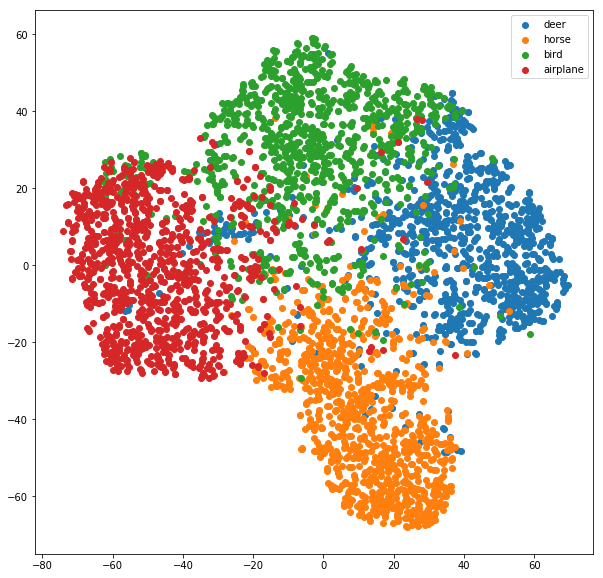

'plt.scatter(X_reduced[len(test_s):, 0], X_reduced[len(test_s):, 1], label="Sneakers")\nplt.scatter(X_reduced[len(test_s):len(test_b)+len(test_s), 0], X_reduced[len(test_s):len(test_b)+len(test_s), 1], label="Boots")\n#plt.scatter(X_reduced[:len(test_s)+len(test_b), 0], X_reduced[:len(test_s)+len(test_b), 1], label="train")\nplt.legend()\nplt.show()'

In [0]:
from sklearn.manifold import TSNE

test_0 = model_s.predict(np.array(test0))
test_1 = model_s.predict(np.array(test1))
test_2 = model_s.predict(np.array(test2))
test_3 = model_s.predict(np.array(test3))

test_0 = test_0.reshape((len(test_0),-1))
test_1 = test_1.reshape((len(test_1),-1))
test_2 = test_2.reshape((len(test_2),-1))
test_3 = test_3.reshape((len(test_3),-1))

#temp = np.vstack((test_s,test_b))
#X_reduced = TSNE(n_components=2).fit_transform(np.vstack((temp,train_s)))
sne = np.vstack((test_0,test_1))
sne = np.vstack((sne,test_2))
sne = np.vstack((sne,test_3))
X_reduced = TSNE(n_components=2).fit_transform(sne)

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[0:len(test_0), 0], X_reduced[0:len(test_0), 1], label="deer")
plt.scatter(X_reduced[len(test_0):len(test_0)+len(test_1), 0], X_reduced[len(test_0):len(test_0)+len(test_1), 1], label="horse")
plt.scatter(X_reduced[len(test_0)+len(test_1):len(test_0)+len(test_1)+len(test_2), 0], X_reduced[len(test_0)+len(test_1):len(test_0)+len(test_1)+len(test_2), 1], label="bird")
plt.scatter(X_reduced[len(test_0)+len(test_1)+len(test_2):, 0], X_reduced[len(test_0)+len(test_1)+len(test_2):, 1], label="airplane")
plt.legend()
plt.show()

"""plt.scatter(X_reduced[len(test_s):, 0], X_reduced[len(test_s):, 1], label="Sneakers")
plt.scatter(X_reduced[len(test_s):len(test_b)+len(test_s), 0], X_reduced[len(test_s):len(test_b)+len(test_s), 1], label="Boots")
#plt.scatter(X_reduced[:len(test_s)+len(test_b), 0], X_reduced[:len(test_s)+len(test_b), 1], label="train")
plt.legend()
plt.show()"""

#metric learning

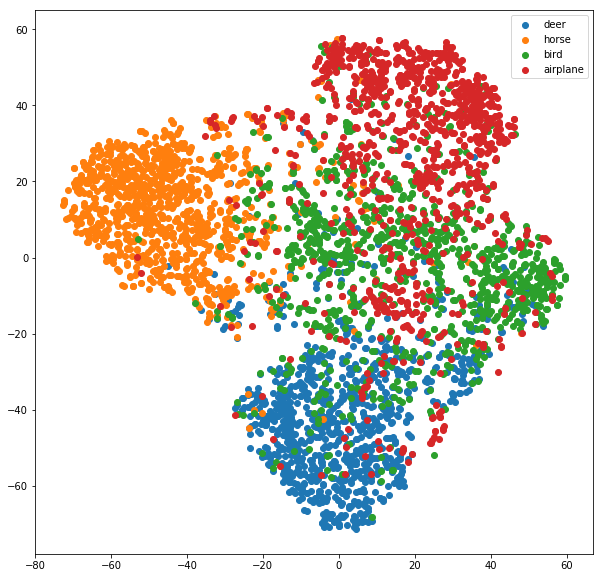

'plt.scatter(X_reduced[len(test_s):, 0], X_reduced[len(test_s):, 1], label="Sneakers")\nplt.scatter(X_reduced[len(test_s):len(test_b)+len(test_s), 0], X_reduced[len(test_s):len(test_b)+len(test_s), 1], label="Boots")\n#plt.scatter(X_reduced[:len(test_s)+len(test_b), 0], X_reduced[:len(test_s)+len(test_b), 1], label="train")\nplt.legend()\nplt.show()'

In [0]:
from sklearn.manifold import TSNE

test_0 = model_s.predict(np.array(test0))
test_1 = model_s.predict(np.array(test1))
test_2 = model_s.predict(np.array(test2))
test_3 = model_s.predict(np.array(test3))

test_0 = test_0.reshape((len(test_0),-1))
test_1 = test_1.reshape((len(test_1),-1))
test_2 = test_2.reshape((len(test_2),-1))
test_3 = test_3.reshape((len(test_3),-1))

#temp = np.vstack((test_s,test_b))
#X_reduced = TSNE(n_components=2).fit_transform(np.vstack((temp,train_s)))
sne = np.vstack((test_0,test_1))
sne = np.vstack((sne,test_2))
sne = np.vstack((sne,test_3))
X_reduced = TSNE(n_components=2).fit_transform(sne)

plt.figure(figsize=(10,10))
plt.scatter(X_reduced[0:len(test_0), 0], X_reduced[0:len(test_0), 1], label="deer")
plt.scatter(X_reduced[len(test_0):len(test_0)+len(test_1), 0], X_reduced[len(test_0):len(test_0)+len(test_1), 1], label="horse")
plt.scatter(X_reduced[len(test_0)+len(test_1):len(test_0)+len(test_1)+len(test_2), 0], X_reduced[len(test_0)+len(test_1):len(test_0)+len(test_1)+len(test_2), 1], label="bird")
plt.scatter(X_reduced[len(test_0)+len(test_1)+len(test_2):, 0], X_reduced[len(test_0)+len(test_1)+len(test_2):, 1], label="airplane")
plt.legend()
plt.show()

"""plt.scatter(X_reduced[len(test_s):, 0], X_reduced[len(test_s):, 1], label="Sneakers")
plt.scatter(X_reduced[len(test_s):len(test_b)+len(test_s), 0], X_reduced[len(test_s):len(test_b)+len(test_s), 1], label="Boots")
#plt.scatter(X_reduced[:len(test_s)+len(test_b), 0], X_reduced[:len(test_s)+len(test_b), 1], label="train")
plt.legend()
plt.show()"""

In [0]:
train_ = []

for i in range(len(x_train)):
    if y_train[i] == 4:
        train_.append(x_train[i])

In [0]:
train_center = model_s.predict(np.array(train_))
train_center = train_center.reshape((len(train_),-1))
center = np.mean(train_center,axis=0)
print(center.shape)

(256,)


(1000, 256)
(1000,)


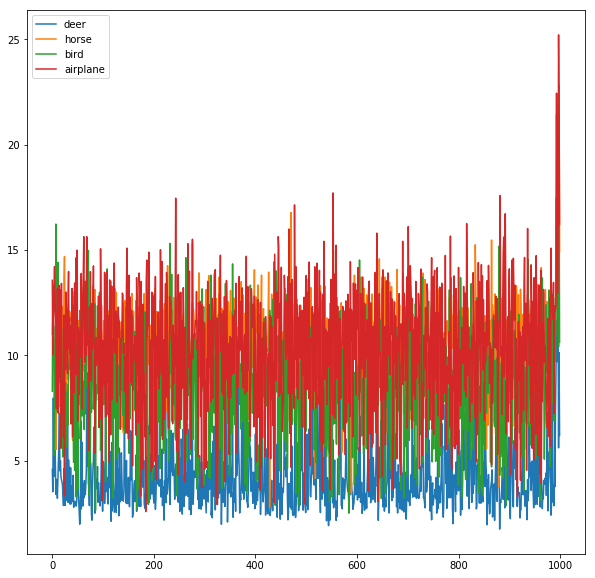

In [0]:
test_0 = model_s.predict(np.array(test0))
test_1 = model_s.predict(np.array(test1))
test_2 = model_s.predict(np.array(test2))
test_3 = model_s.predict(np.array(test3))

test_0 = test_0.reshape((len(test_0),-1))
test_1 = test_1.reshape((len(test_1),-1))
test_2 = test_2.reshape((len(test_2),-1))
test_3 = test_3.reshape((len(test_3),-1))

print(test_0.shape)

test_0 = np.linalg.norm(test_0 - center,ord=1,axis=1)
test_1 = np.linalg.norm(test_1 - center,ord=1,axis=1)
test_2 = np.linalg.norm(test_2 - center,ord=1,axis=1)
test_3 = np.linalg.norm(test_3 - center,ord=1,axis=1)

print(test_0.shape)


plt.figure(figsize=(10,10))
plt.plot(test_0, label="deer")
plt.plot(test_1, label="horse")
plt.plot(test_2, label="bird")
plt.plot(test_3, label="airplane")
plt.legend()
plt.show()

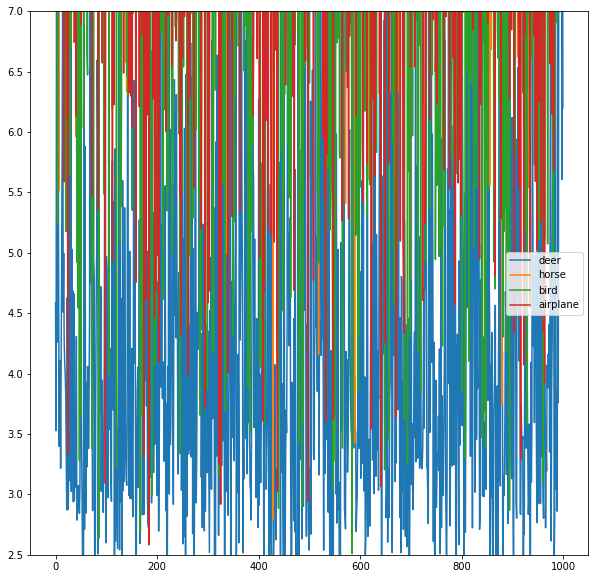

In [0]:
plt.figure(figsize=(10,10))
plt.plot(test_0, label="deer")
plt.plot(test_1, label="horse")
plt.plot(test_2, label="bird")
plt.plot(test_3, label="airplane")
plt.ylim(2.5,7)
plt.legend()
plt.show()